# Explore the datasets provided

Two datasets have been provided with this repository. 
- `ed_visits.csv` 
- `inpatient_arrivals.csv`

These accompany my fully worked example of the modelling of emergency demand for beds. But they are also useful to illustrate what patient shapshots might be made up of. 

This notebook does some data exploration by plotting charts of all relevant variables in each dataset. 

The `inpatient_arrivals` dataset contains arrival times of all patients who visited the UCLH Emergency Department (ED) and the Same Day Emergency Care (SDEC) unit, over the period of the data, and were later admitted. It includes their sex, child status (whether adult or child), and a column to assign each one to training, validation and test sets.

The `ed_visits` database contains a set of snapshots of patients who visited the ED and SDEC over the period of the data, including both admitted and discharged patients. Each snapshot includes information known at the time of the snapshot, and excludes anything that was recorded later, except the variables that serve a 'labels' for model training. These are:   
- `is_admitted` - whether the visit ended in admission to a ward
- `final_sequence` - the sequence of consultations the patient had during the visit
- `specialty` - the specialty of the admission, if the patient was admitted

See the [data dictionaries](../data-dictionaries/) for detailed information about the variables in the data provided.

## Learn more about the data

I recorded a webinar to demonstrate how we converted data from the UCLH Electronic Health Record in a form suitable for this modelling. If you click on the image below, the video will open at the point where I provide detail about the datasets 

<a href="https://www.youtube.com/watch?v=ha_zckz3_rU&t=262s" target="_blank">
    <img src="img/thumbnail_NHSR_webinar.jpg" alt="Link to webinar on how to turn your EHR data into predictions of demand for emergency beds" width="600"/>
</a>



## Set up the notebook environment


In [7]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from patientflow.load import set_project_root
project_root = set_project_root()

Inferred project root: /Users/zellaking/Repos/patientflow


## Load parameters and set file paths

Parameters are set in config.json and (for UCLH implementation in config-uclh.yaml). You can change these for your own purposes. I'll talk more about the role of each parameter as it becomes relevant. Here we are loading the pre-defned training, validation and test set dates.  

For more information about parameters and file paths, see notebook [4a_Predict_probability_of_admission_from_ED.ipynb](4a_Predict_probability_of_admission_from_ED.ipynb)

In [11]:
from patientflow.load import set_file_paths, load_config_file

# indicate whether the notebook is being run locally for UCLH or with public datasets
uclh = False

# set file paths
data_file_path, media_file_path, model_file_path, config_path = set_file_paths(
        project_root, 
        data_folder_name='data-public',  # change this to data-synthetic if you don't have the public dataset
        verbose=False
        ) 

# load parameters
params = load_config_file(config_path)
start_training_set, start_validation_set, start_test_set, end_test_set = params["start_training_set"], params["start_validation_set"], params["start_test_set"], params["end_test_set"]


## Load data

This notebook has been run using real data which you can download from [Zenodo](https://zenodo.org/records/14866057) on request. 

Alternatively you can use the synthetic data that has been created from the distributions of real patient data. The method used to create the synthetic data was to generate sample values following the statistics reported in the [data dictionaries](../data-dictionaries/). 

If you don't have the public data, change the argument in the cell above from `data_folder_name='data-public'` to `data_folder_name='data-synthetic'`.


In [12]:
import pandas as pd
from patientflow.load import load_data

ed_visits = load_data(data_file_path, 
                    file_name='ed_visits.csv', 
                    index_column = 'snapshot_id',
                    sort_columns = ["visit_number", "snapshot_date", "prediction_time"], 
                    eval_columns = ["prediction_time", "consultation_sequence", "final_sequence"])

inpatient_arrivals = load_data(data_file_path, 
                    file_name='inpatient_arrivals.csv', 
                    index_column = 'snapshot_id',)

ed_visits.head()

,snapshot_date,prediction_time,visit_number,elapsed_los,sex,age_group,arrival_method,current_location_type,total_locations_visited,num_obs,...,latest_lab_results_na,latest_lab_results_pco2,latest_lab_results_ph,latest_lab_results_wcc,latest_lab_results_alb,latest_lab_results_htrt,final_sequence,is_admitted,random_number,specialty
snapshot_id,,,,,,,,,,,,,,,,,,,,,
0,4/17/2031,"(12, 0)",30767,1920,F,55-64,Ambulance,majors,4,107,...,NaN,NaN,NaN,NaN,NaN,NaN,[],False,15795,medical
1,4/17/2031,"(15, 30)",30767,14520,F,55-64,Ambulance,majors,5,138,...,138.0,4.61,7.474,8.77,NaN,NaN,[],False,860,medical
2,12/10/2031,"(15, 30)",36297,9180,M,75-102,NaN,majors,4,127,...,140.0,4.82,7.433,6.59,NaN,NaN,[],False,76820,surgical
3,3/28/2031,"(6, 0)",53554,2220,F,35-44,Public Trans,rat,3,356,...,NaN,NaN,NaN,NaN,NaN,NaN,[],False,54886,medical
4,3/28/2031,"(9, 30)",53554,14820,F,35-44,Public Trans,majors,4,375,...,139.0,4.00,7.536,13.03,NaN,NaN,[],False,6265,medical


## Explore visits dataset

Note that each snapshot has a date and a prediction time formatted separately. 

In [13]:
ed_visits.head(10)

,snapshot_date,prediction_time,visit_number,elapsed_los,sex,age_group,arrival_method,current_location_type,total_locations_visited,num_obs,...,latest_lab_results_na,latest_lab_results_pco2,latest_lab_results_ph,latest_lab_results_wcc,latest_lab_results_alb,latest_lab_results_htrt,final_sequence,is_admitted,random_number,specialty
snapshot_id,,,,,,,,,,,,,,,,,,,,,
0,4/17/2031,"(12, 0)",30767,1920,F,55-64,Ambulance,majors,4,107,...,NaN,NaN,NaN,NaN,NaN,NaN,[],False,15795,medical
1,4/17/2031,"(15, 30)",30767,14520,F,55-64,Ambulance,majors,5,138,...,138.0,4.61,7.474,8.77,NaN,NaN,[],False,860,medical
2,12/10/2031,"(15, 30)",36297,9180,M,75-102,NaN,majors,4,127,...,140.0,4.82,7.433,6.59,NaN,NaN,[],False,76820,surgical
3,3/28/2031,"(6, 0)",53554,2220,F,35-44,Public Trans,rat,3,356,...,NaN,NaN,NaN,NaN,NaN,NaN,[],False,54886,medical
4,3/28/2031,"(9, 30)",53554,14820,F,35-44,Public Trans,majors,4,375,...,139.0,4.00,7.536,13.03,NaN,NaN,[],False,6265,medical
5,03/05/2031,"(22, 0)",60303,14880,M,65-74,NaN,rat,6,19,...,NaN,NaN,NaN,NaN,NaN,NaN,['haem_onc'],False,37194,haem/onc
8,7/17/2031,"(12, 0)",62538,50340,F,25-34,Walk-in,sdec,6,972,...,NaN,NaN,NaN,NaN,NaN,NaN,['surgical'],False,16023,surgical
9,7/17/2031,"(15, 30)",62538,62940,F,25-34,Walk-in,sdec,6,989,...,NaN,NaN,NaN,NaN,NaN,NaN,['surgical'],False,41090,surgical
6,7/17/2031,"(6, 0)",62538,28740,F,25-34,Walk-in,sdec,6,920,...,NaN,NaN,NaN,NaN,NaN,NaN,['surgical'],False,44131,surgical


### Grouping of columns in ED visits dataset

The ED visits dataset contains variables of different types. 

For convenience, I use a function called `get_dict_cols()` to organise the charts below into different sections.

In [14]:
from patientflow.load import get_dict_cols
dict_cols = get_dict_cols(ed_visits)

for key, value in dict_cols.items():
    print(f"\nColumns in group called {key}:")
    print(value)




Columns in group called not used in training:
['snapshot_id', 'snapshot_date', 'prediction_time', 'visit_number', 'training_validation_test', 'random_number']

Columns in group called arrival and demographic:
['elapsed_los', 'sex', 'age_group', 'age_on_arrival', 'arrival_method']

Columns in group called summary:
['num_obs', 'num_obs_events', 'num_obs_types', 'num_lab_batteries_ordered']

Columns in group called location:
['current_location_type', 'total_locations_visited', 'visited_majors', 'visited_otf', 'visited_paeds', 'visited_rat', 'visited_resus', 'visited_sdec', 'visited_sdec_waiting', 'visited_unknown', 'visited_utc', 'visited_waiting']

Columns in group called observations:
['num_obs_blood_pressure', 'num_obs_pulse', 'num_obs_air_or_oxygen', 'num_obs_glasgow_coma_scale_best_motor_response', 'num_obs_level_of_consciousness', 'num_obs_news_score_result', 'num_obs_manchester_triage_acuity', 'num_obs_objective_pain_score', 'num_obs_subjective_pain_score', 'num_obs_temperature', 

Also for the plots, I convert the boolean columns to text values.

In [15]:
# Function to convert boolean columns to text values "true" or "false" - used for plotting format
def bool_to_text(df):
    bool_cols = df.select_dtypes(include='bool').columns.drop('is_admitted')
    for col in bool_cols:
        df[col] = df[col].apply(lambda x: 'true' if x else 'false')
    return df

# Apply the function
ed_visits = bool_to_text(ed_visits)

# temporarily add a is_admitted column to arrivals 
inpatient_arrivals['is_admitted'] = True
inpatient_arrivals = bool_to_text(inpatient_arrivals)

As some variables are ordinal, I create a dictionary to record the ordering of the values. 

In [16]:
ordinal_mappings = {
    # age group
    "age_group": [
        "0-17",
        "18-24",
        "25-34",
        "35-44",
        "45-54",
        "55-64",
        "65-74",
        "75-102",
    ],
    # triage score
    "latest_obs_manchester_triage_acuity": ["Blue", "Green", "Yellow", "Orange", "Red"],
    # pain score
    "latest_obs_objective_pain_score": [
        r"Nil",
        r"Mild",
        r"Moderate",
        r"Severe\E\Very Severe",
    ],
    # level of consciousness
    "latest_obs_level_of_consciousness": [
        "A", #alert
        "C", #confused
        "V", #voice - responds to voice stimulus
        "P", #pain - responds to pain stimulus
        "U" #unconscious - no response to pain or voice stimulus
    ]
}



### Arrival and demographic variables

Here I import a function called plot_data_distributions to provide a convenient way of requesting each plot without multiple lines of code for each.

In [18]:
from patientflow.viz.distribution_plots import plot_data_distributions



#### Elapsed Length of Stay

Both admitted and not admitted visits appear to have a long tail of visits lasting more than 24 hours. Note that the data extraction that has created this dataset has not included any snapshots where the ED visit has lasted more than 72 hours. 


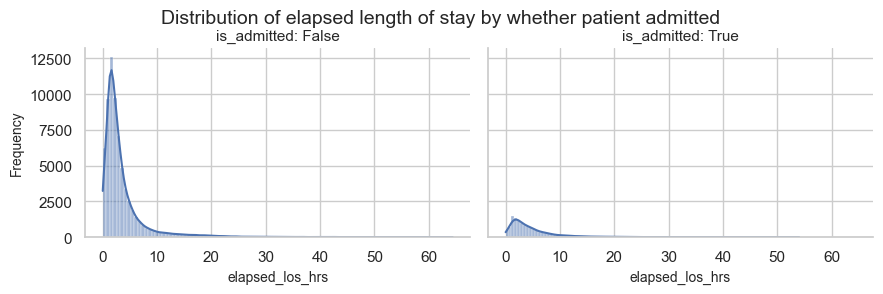

In [44]:
ed_visits['elapsed_los_hrs'] = ed_visits['elapsed_los']/3600
plot_data_distributions(df=ed_visits, col_name='elapsed_los_hrs', grouping_var='is_admitted', grouping_var_name='whether patient admitted', plot_type='both',
                        title = 'Distribution of elapsed length of stay by whether patient admitted')

Note that each record in the snapshots dataframe is indexed by a unique snapshot_id. 

Plotting only the snapshots where the elapsed visit duration is less than 10 hours shows a jump at around 1 hour. The reason for this is unclear. 

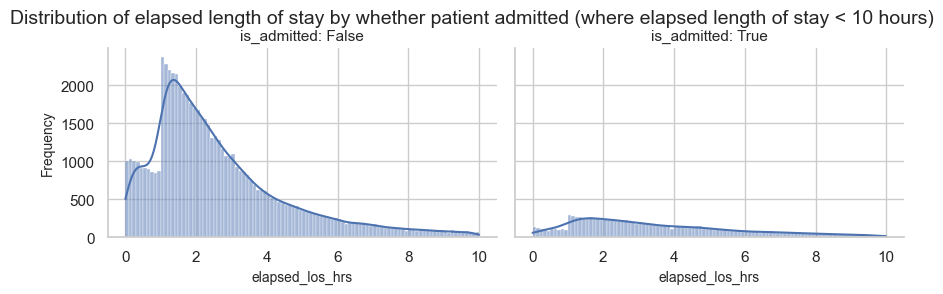

In [47]:
plot_data_distributions(ed_visits[ed_visits.elapsed_los_hrs < 10], 'elapsed_los_hrs', 'is_admitted', 'whether patient admitted', plot_type='both', 
                        title = 'Distribution of elapsed length of stay by whether patient admitted (where elapsed length of stay < 10 hours)')

Below, I plot the snapshots where the elapsed visit duration is greater than 24 hours. We can see that the long tail of longer visits is more numerous for discharged than for admitted patients. We are not sure why that would be the case. 

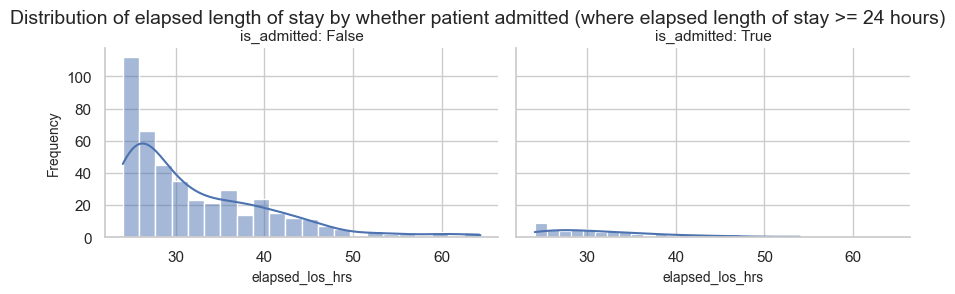

In [49]:
if ed_visits[ed_visits.elapsed_los_hrs >= 24].shape[0] > 0:
    plot_data_distributions(ed_visits[ed_visits.elapsed_los_hrs >= 24], 'elapsed_los_hrs', 'is_admitted', 'whether patient admitted', plot_type='both',
                        title = 'Distribution of elapsed length of stay by whether patient admitted (where elapsed length of stay >= 24 hours)')

#### Sex, age group and arrival method

The charts below show distributions between admitted and not admitted patients for sex, age group and arrival method. More older people are admitted. Most walk-ins are discharged.

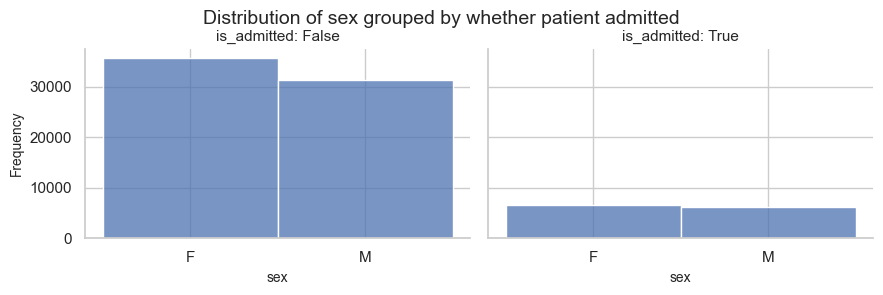

In [50]:
plot_data_distributions(ed_visits, 'sex', 'is_admitted', 'whether patient admitted', plot_type='hist')

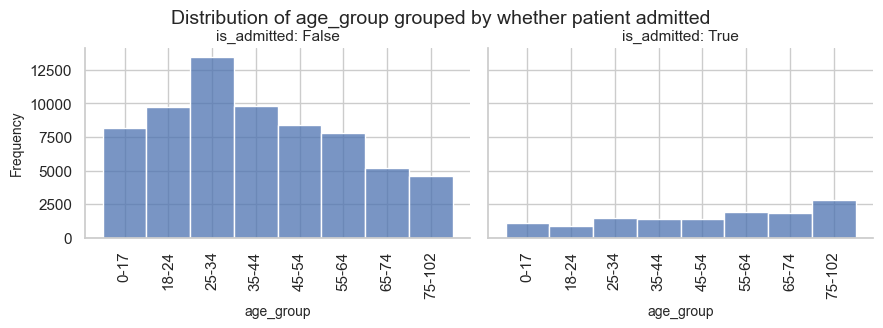

In [51]:
if 'age_group' in ed_visits.columns:
    plot_data_distributions(ed_visits, 'age_group', 'is_admitted', 'whether patient admitted', plot_type='hist', ordinal_order=ordinal_mappings['age_group'], rotate_x_labels = True)
else:
    plot_data_distributions(ed_visits, 'age_on_arrival', 'is_admitted', 'whether patient admitted', plot_type='hist')


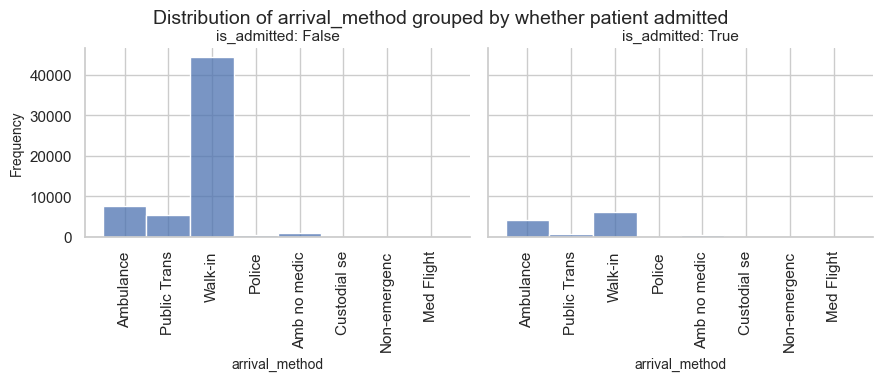

In [52]:
plot_data_distributions(ed_visits, 'arrival_method', 'is_admitted', 'whether patient admitted', plot_type='hist', rotate_x_labels = True)

### Count variables

The counts variables record the following, up to the moment of the snapshot
* the number of observations recorded
* the number of events at which observations were recorded (if heart rate and respiratory rate have the same timestamp in the original data, this is one event)
* the number of different types of observations (heart rate and respiratory would be two types)
* the number of lab test batteries ordered

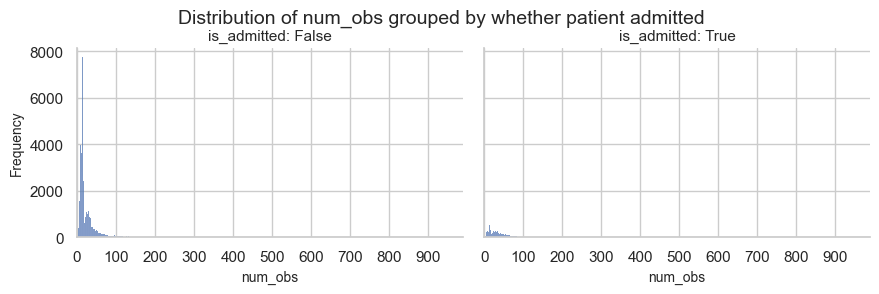

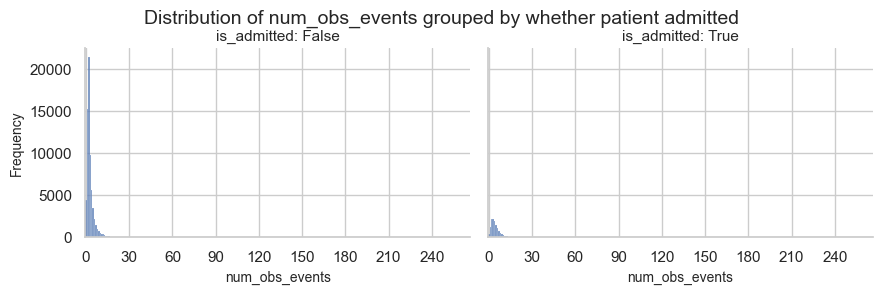

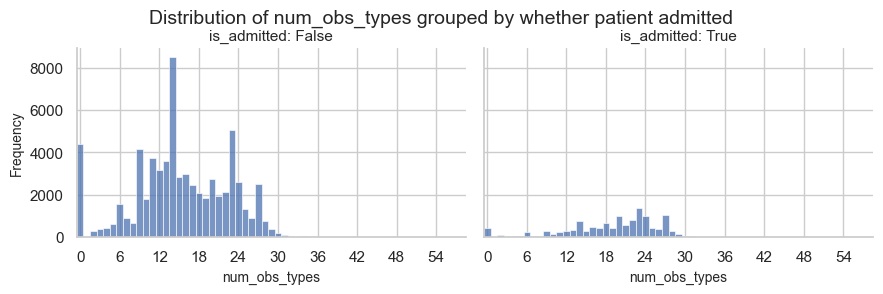

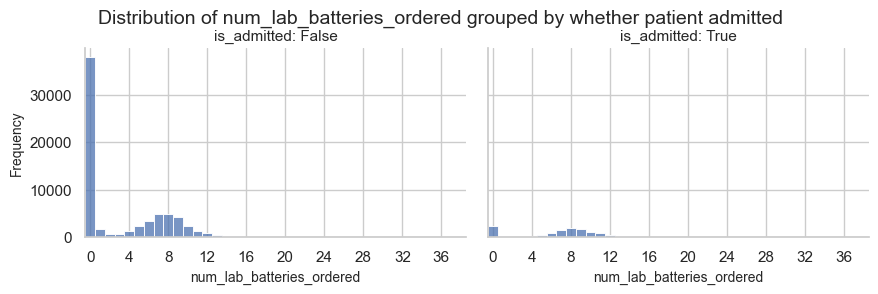

In [53]:
for col_name in dict_cols['summary']:
    plot_data_distributions(ed_visits, col_name, 'is_admitted', 'whether patient admitted', plot_type='hist', is_discrete = True)

In [54]:
print(ed_visits.num_obs.max())
print(ed_visits.num_obs_events.max())

989
266


### Location variables

The variable `current_location_type` records the location of the patient at the time of the snapshot. Refer to the [data dictionary](../data-dictionaries/ed_visits_data_dictionary.csv) for more information about what each location type means. Patients who visit the UTC (Urgent Treatment Centre) are more likely to be discharged than admitted. The UTC provides care for patients with minor injuries and illnesses.

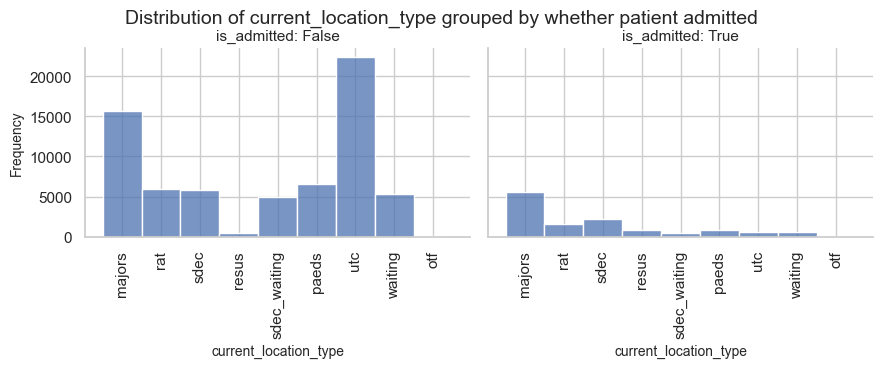

In [55]:
plot_data_distributions(ed_visits, 'current_location_type', 'is_admitted', 'whether patient admitted', plot_type='hist', rotate_x_labels = True)

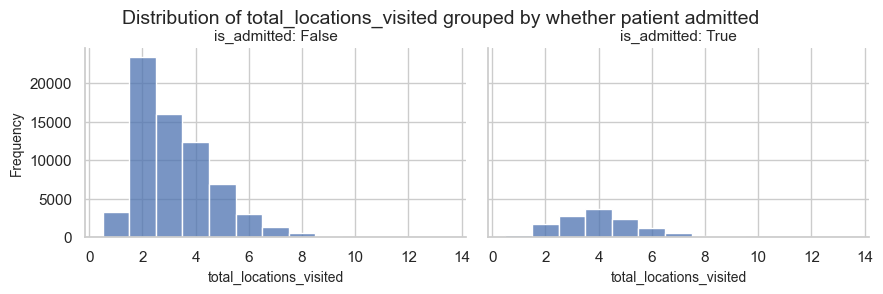

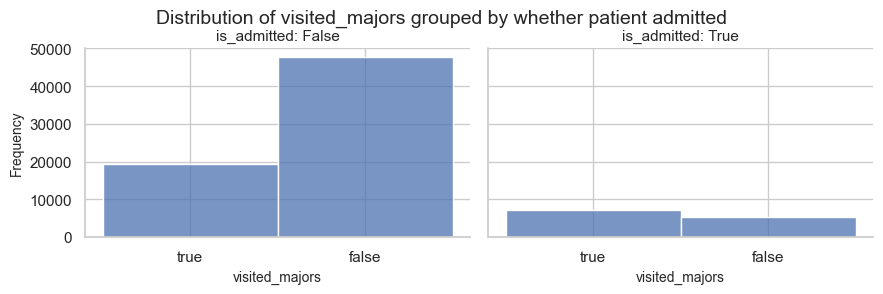

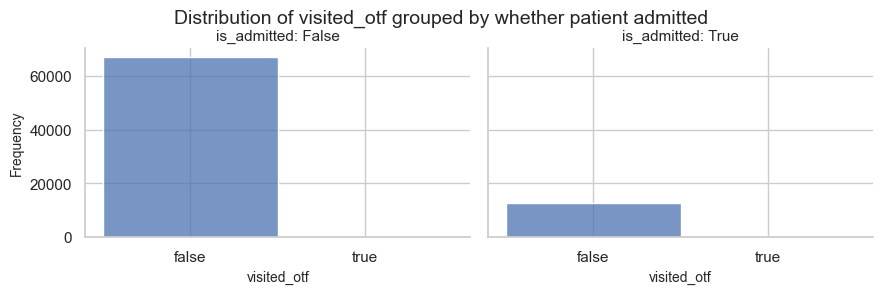

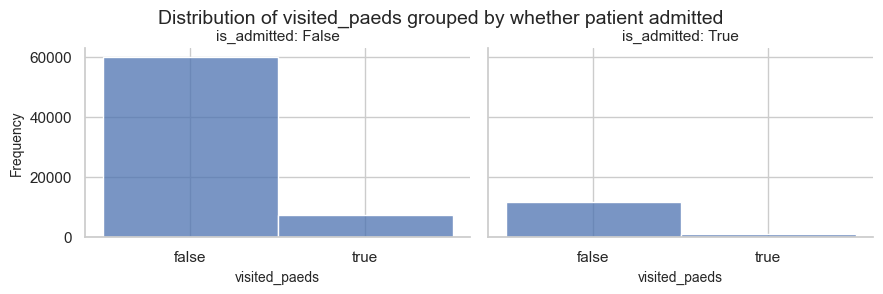

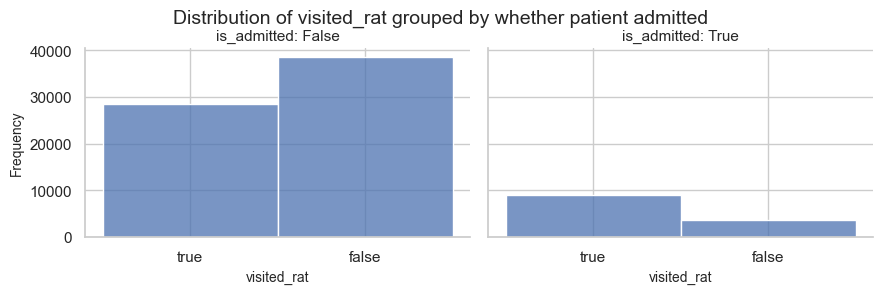

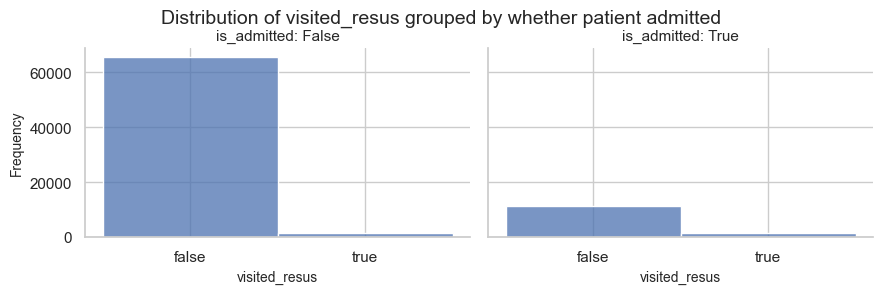

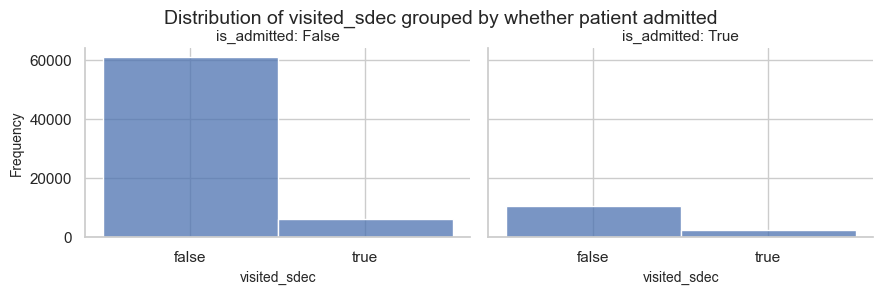

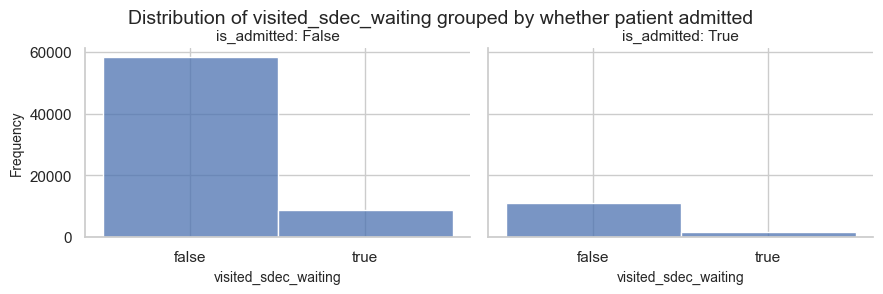

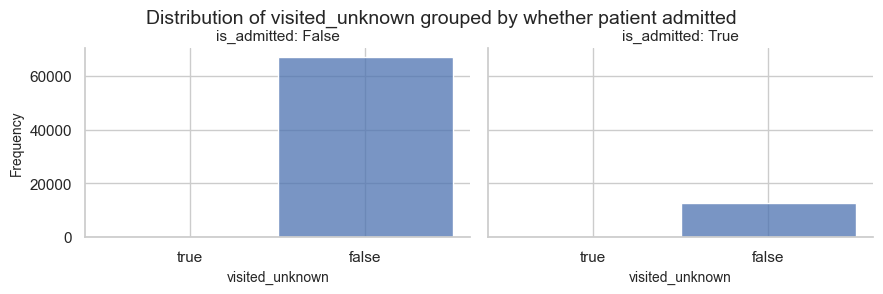

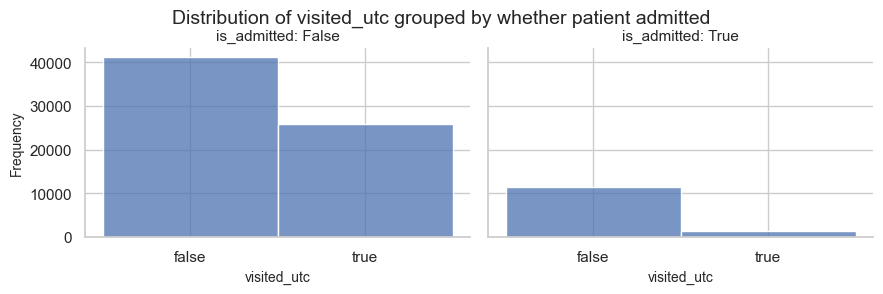

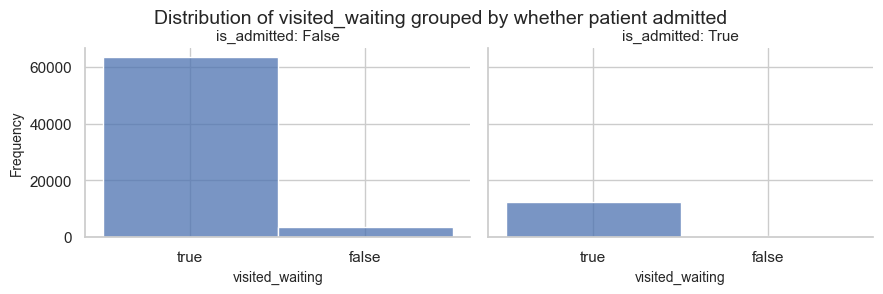

In [56]:
for col_name in dict_cols['location'][1:]:
    plot_data_distributions(ed_visits, col_name, 'is_admitted', 'whether patient admitted', plot_type='hist')

### Observations variables

The variables in the observations group record vital signs, triage scores, and also the number of times certain observations have been recorded, up to the moment of the snapshot.

In [57]:
dict_cols['observations']

['num_obs_blood_pressure',
 'num_obs_pulse',
 'num_obs_air_or_oxygen',
 'num_obs_glasgow_coma_scale_best_motor_response',
 'num_obs_level_of_consciousness',
 'num_obs_news_score_result',
 'num_obs_manchester_triage_acuity',
 'num_obs_objective_pain_score',
 'num_obs_subjective_pain_score',
 'num_obs_temperature',
 'num_obs_oxygen_delivery_method',
 'num_obs_pupil_reaction_right',
 'num_obs_oxygen_flow_rate',
 'num_obs_uclh_sskin_areas_observed',
 'latest_obs_pulse',
 'latest_obs_respirations',
 'latest_obs_level_of_consciousness',
 'latest_obs_news_score_result',
 'latest_obs_manchester_triage_acuity',
 'latest_obs_objective_pain_score',
 'latest_obs_temperature']

I first plot the variables that count the number of times something was recorded. 

#### Count variables

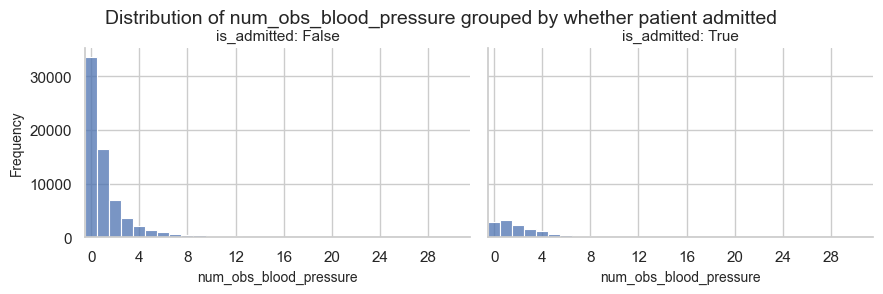

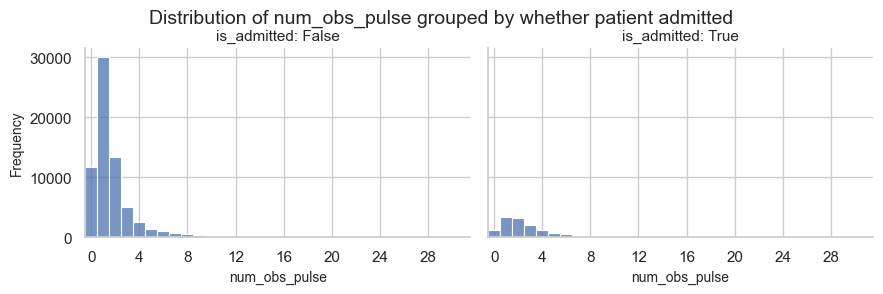

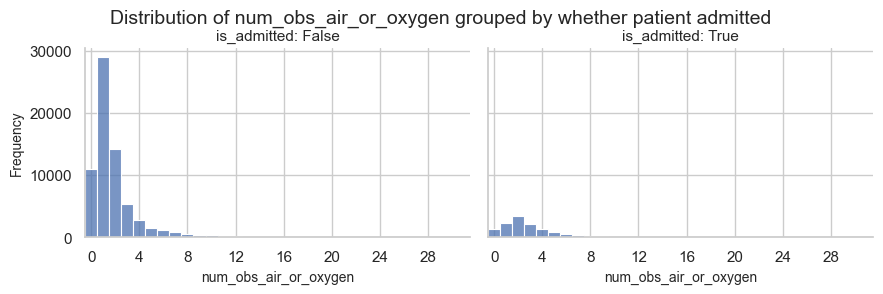

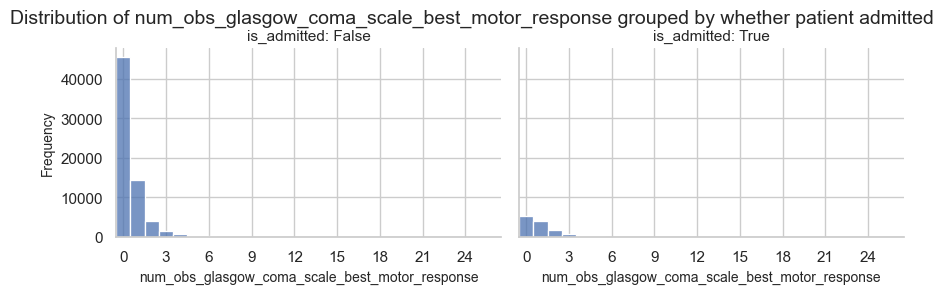

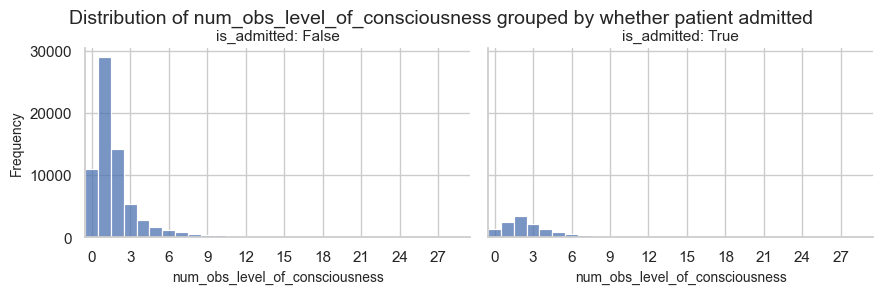

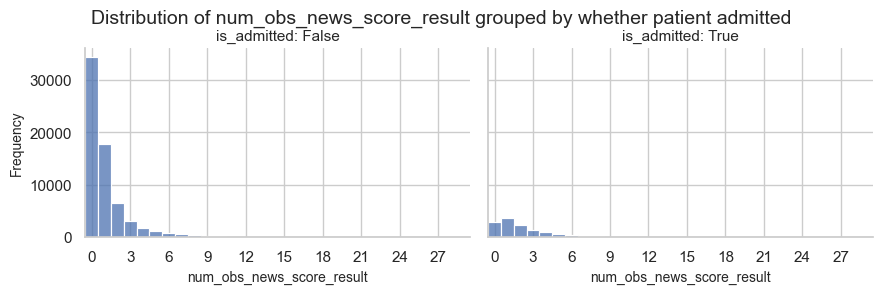

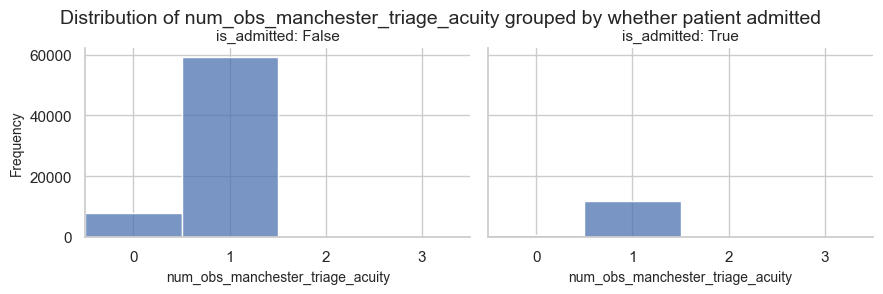

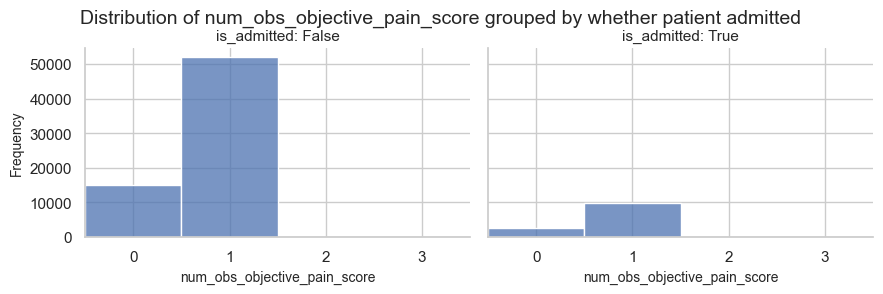

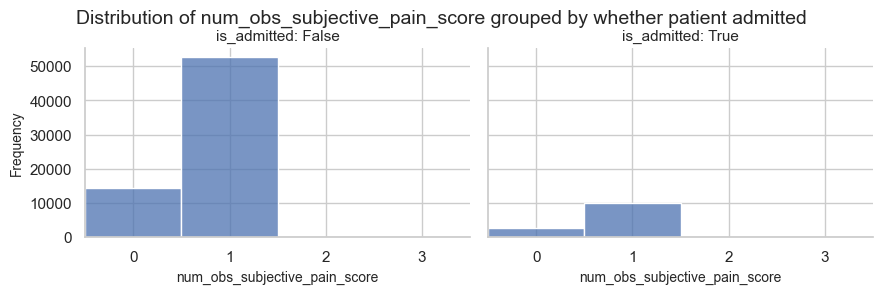

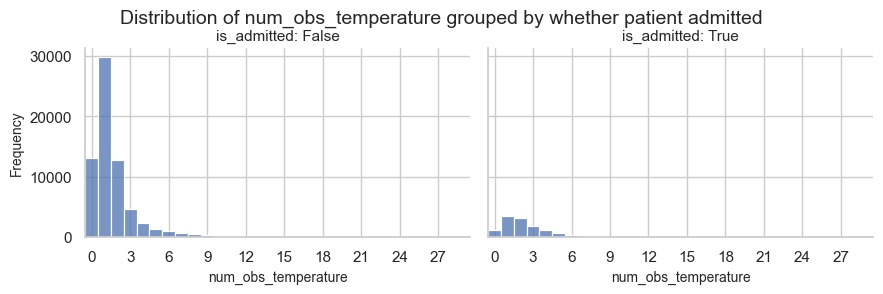

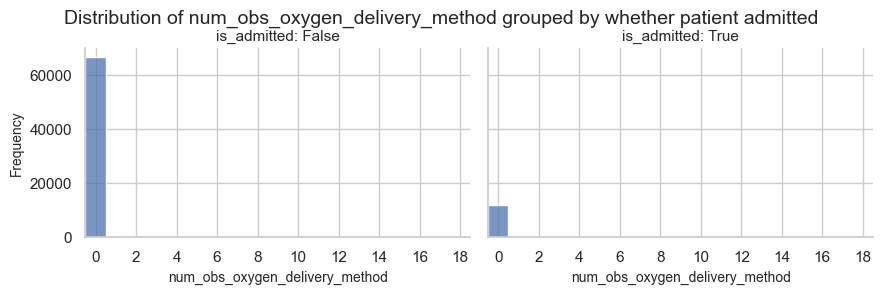

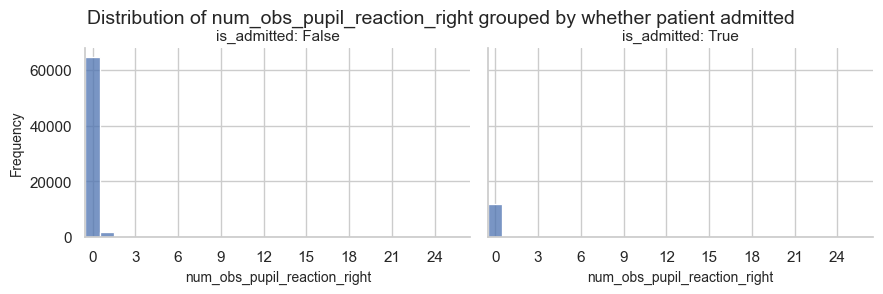

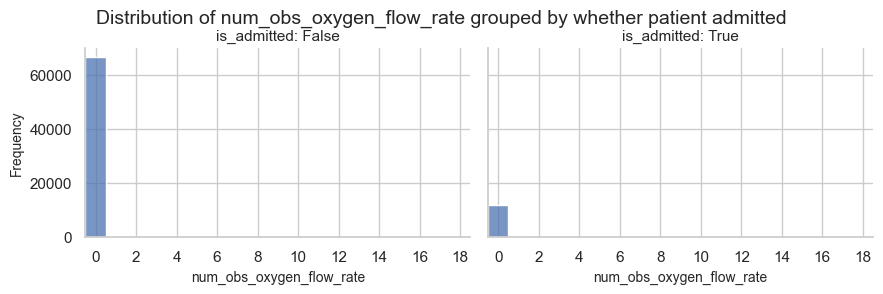

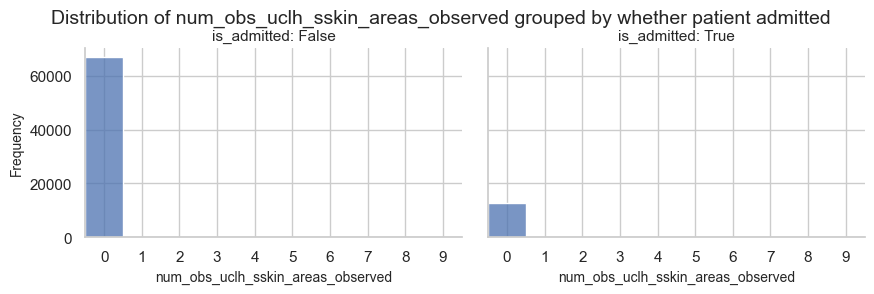

In [58]:
for col_name in [item for item in dict_cols['observations'] if str(item).startswith('num')]:
    plot_data_distributions(ed_visits, col_name, 'is_admitted', 'whether patient admitted', plot_type='hist', is_discrete = True)

#### News Scores and Manchester Triage score values

News Scores are commonly used to track the acuity of a patient, and Manchester Triage scores are used at the door of the ED to prioritise patients

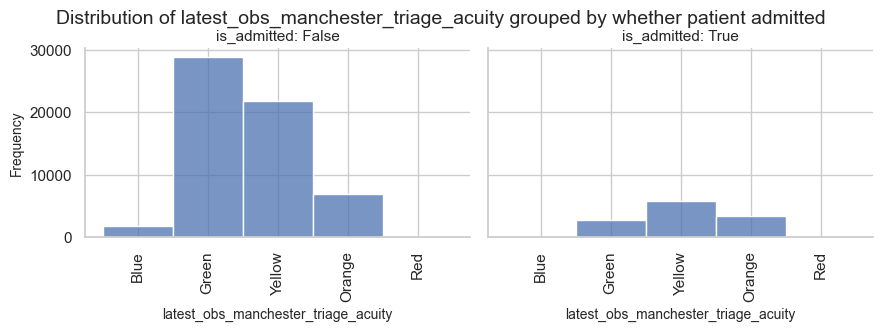

In [59]:
for col_name in [item for item in dict_cols['observations'] if ('manchester' in str(item) ) and str(item).startswith('latest')]:
    plot_data_distributions(ed_visits, col_name, 'is_admitted', 'whether patient admitted', plot_type='hist', rotate_x_labels = True, ordinal_order=ordinal_mappings['latest_obs_manchester_triage_acuity'])

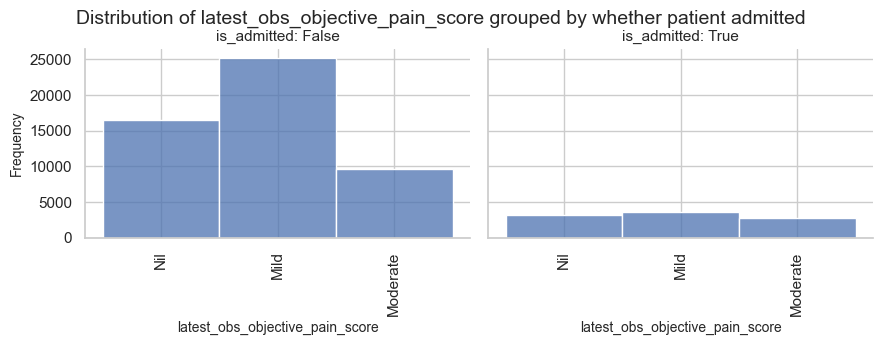

In [60]:
plot_data_distributions(ed_visits, 'latest_obs_objective_pain_score', 'is_admitted', 'whether patient admitted', plot_type='hist', rotate_x_labels = True, ordinal_order=ordinal_mappings['latest_obs_objective_pain_score'])


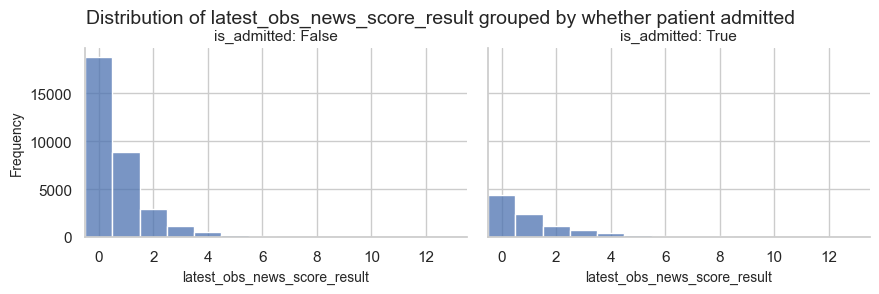

In [61]:

for col_name in [item for item in dict_cols['observations'] if 'news' in str(item) and str(item).startswith('latest')]:
    plot_data_distributions(ed_visits, col_name, 'is_admitted', 'whether patient admitted', plot_type='hist', is_discrete = True)

The ACVPU score is commonly used to track states of consciousness

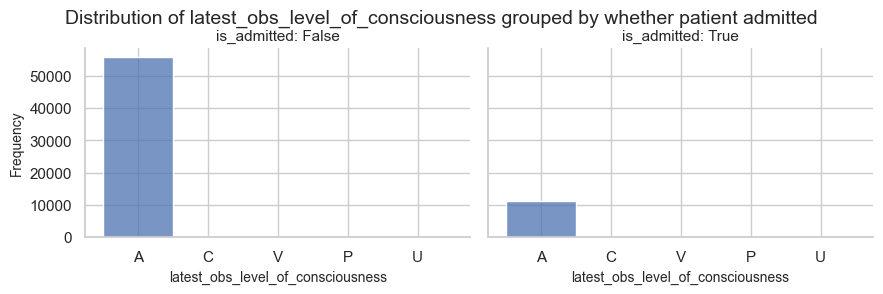

In [62]:
for col_name in [item for item in dict_cols['observations'] if 'consciousness' in str(item) and str(item).startswith('latest')]:
    plot_data_distributions(ed_visits, col_name, 'is_admitted', 'whether patient admitted', plot_type='hist', ordinal_order=ordinal_mappings['latest_obs_level_of_consciousness'])

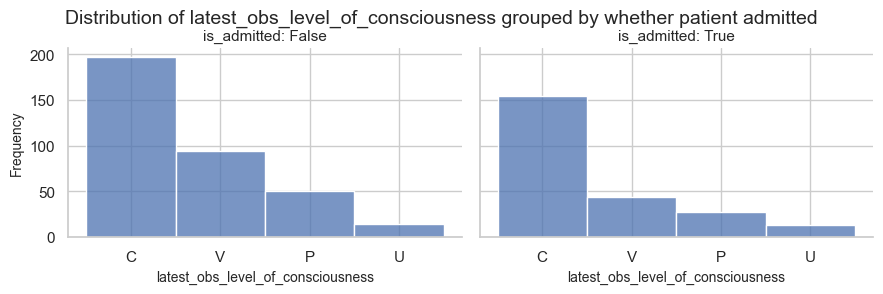

In [63]:
for col_name in [item for item in dict_cols['observations'] if 'consciousness' in str(item) and str(item).startswith('latest')]:
    plot_data_distributions(ed_visits[~(ed_visits.latest_obs_level_of_consciousness == 'A')].copy(), col_name, 'is_admitted', 'whether patient admitted', plot_type='hist', ordinal_order=ordinal_mappings['latest_obs_level_of_consciousness'])

#### Vital signs values

I now plot the distributions of the vital signs values.

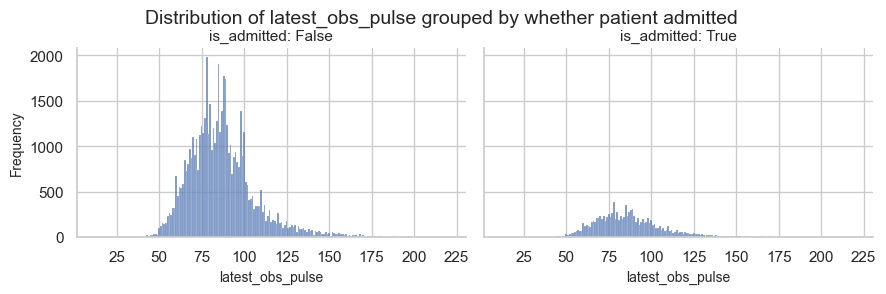

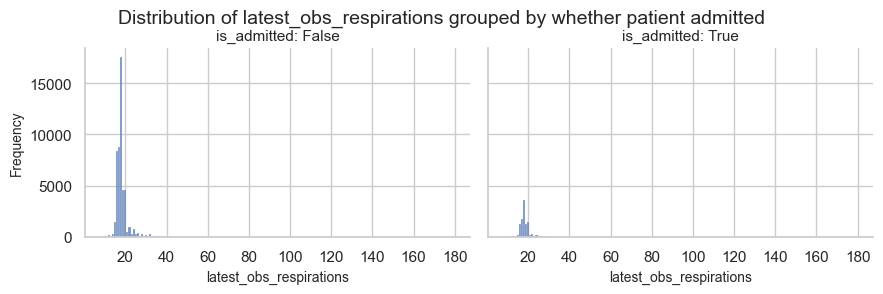

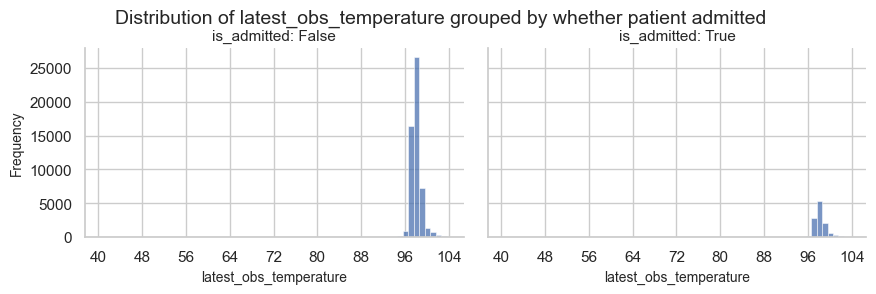

In [64]:
for col_name in [item for item in dict_cols['observations'] if str(item).startswith('latest') and ('pulse' in str(item) or 'resp' in str(item) or 'temp' in str(item))]:
    plot_data_distributions(ed_visits, col_name, 'is_admitted', 'whether patient admitted', plot_type='hist', is_discrete = True)

Above, the temperature range goes as low as 40 degrees, which suggests that the date contain both Celsius and Fahrenheit values. I will need to correct this in the data cleaning process.

### Lab variables

The lab variables include boolean values for whether a lab battery was ordered, and the results of certain lab test. The data include only a small a subset of the lab battery orders and test results that might be requested for a patient in the ED. 

In [65]:
dict_cols['lab orders and results']

['lab_orders_bc',
 'lab_orders_bon',
 'lab_orders_crp',
 'lab_orders_csnf',
 'lab_orders_ddit',
 'lab_orders_ncov',
 'lab_orders_rflu',
 'lab_orders_xcov',
 'latest_lab_results_crea',
 'latest_lab_results_hctu',
 'latest_lab_results_k',
 'latest_lab_results_lac',
 'latest_lab_results_na',
 'latest_lab_results_pco2',
 'latest_lab_results_ph',
 'latest_lab_results_wcc',
 'latest_lab_results_alb',
 'latest_lab_results_htrt']

#### Lab orders

It is notable in the charts below, which show whether a lab battery was ordered, that battery CRP (for markers of inflammation) is very commonly ordered for admitted patients; among the patients later admitted the majority have a CRP battery ordered whereas among the non-admitted patients only a minority have it. This difference between admitted and non-admitted (where the majority of admitted have something while the majority of discharged patients do not) only applies to this lab battery order. It will show up later as a strong predictor of admission.

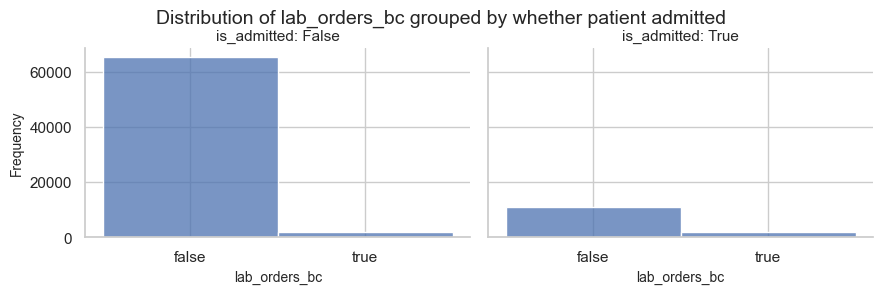

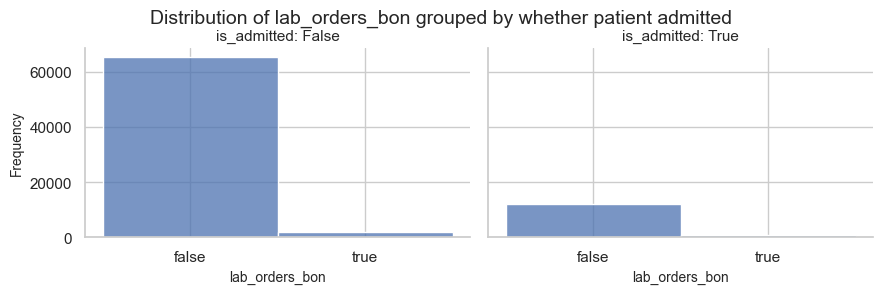

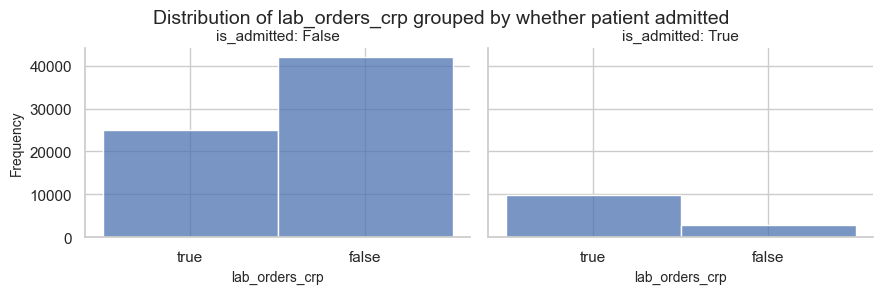

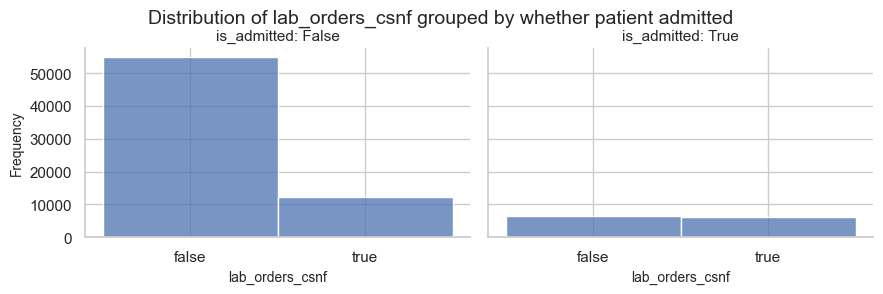

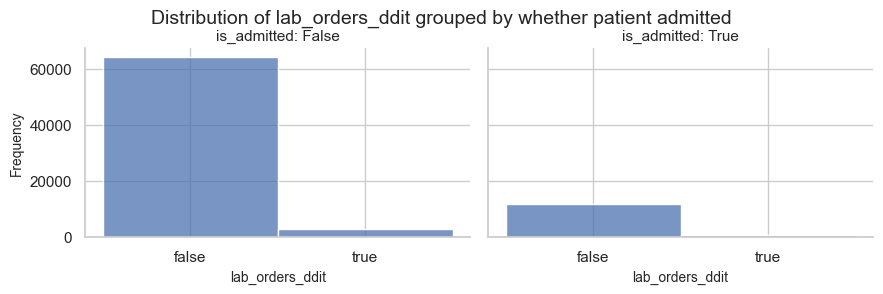

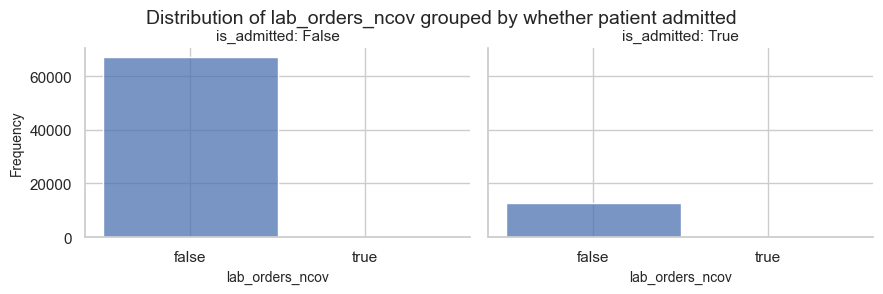

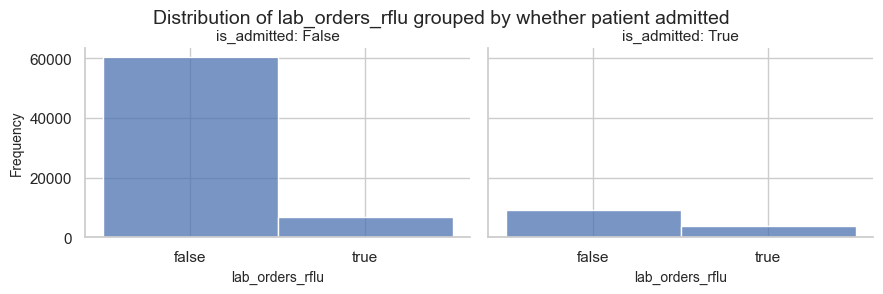

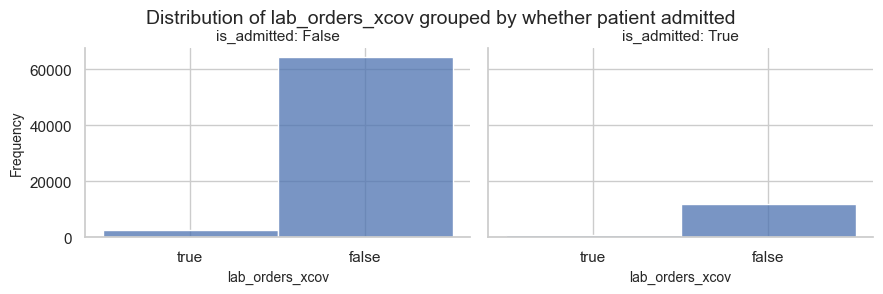

In [66]:
for col_name in [item for item in dict_cols['lab orders and results'] if str(item).startswith('lab') ]:
    plot_data_distributions(ed_visits, col_name, 'is_admitted', 'whether patient admitted', plot_type='hist')

#### Lab results

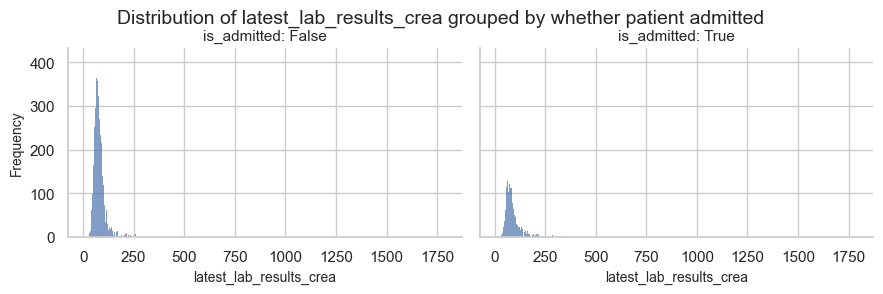

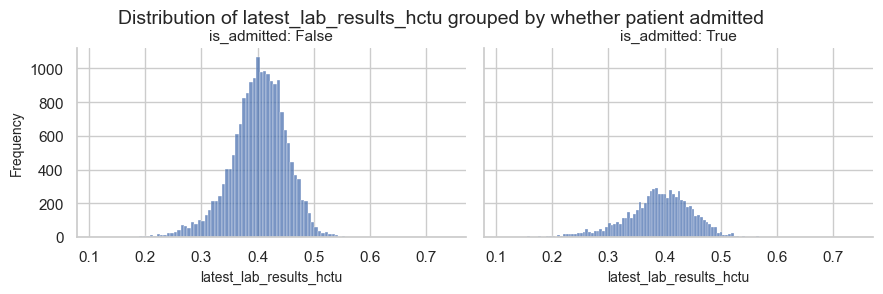

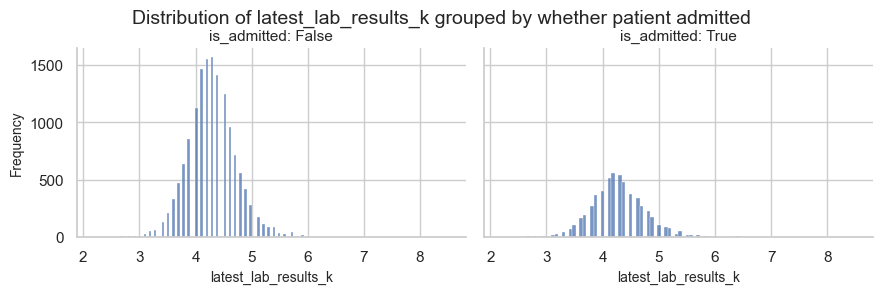

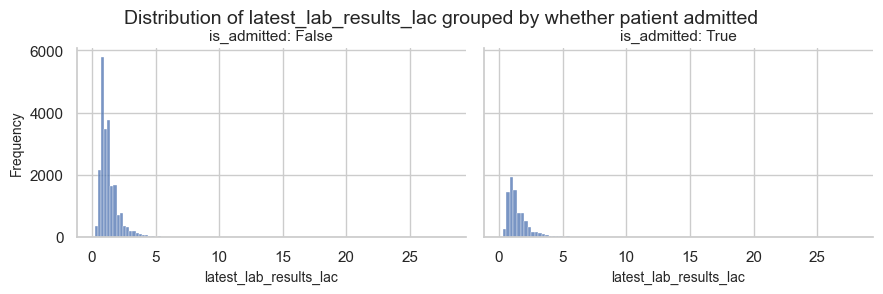

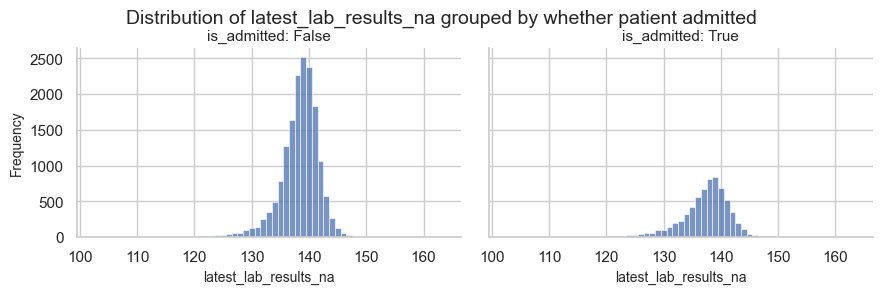

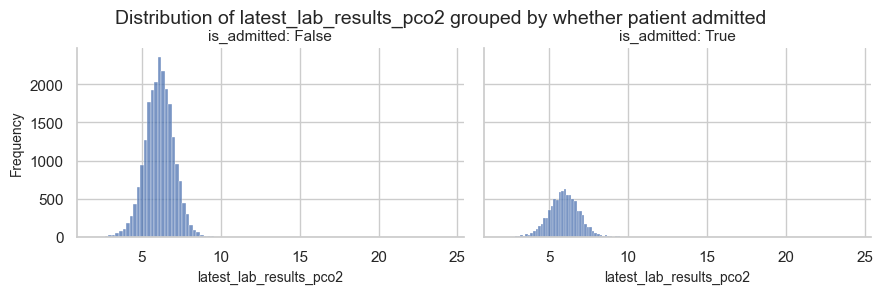

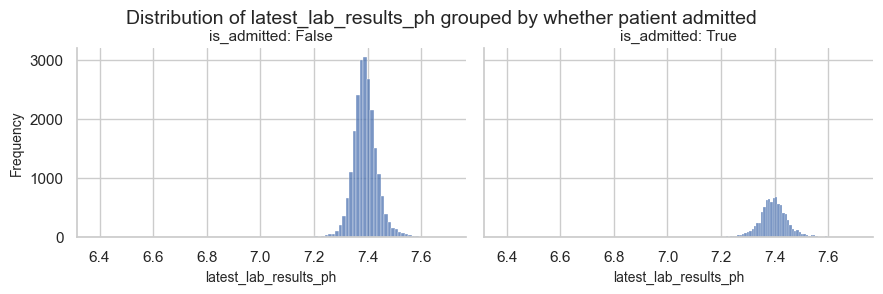

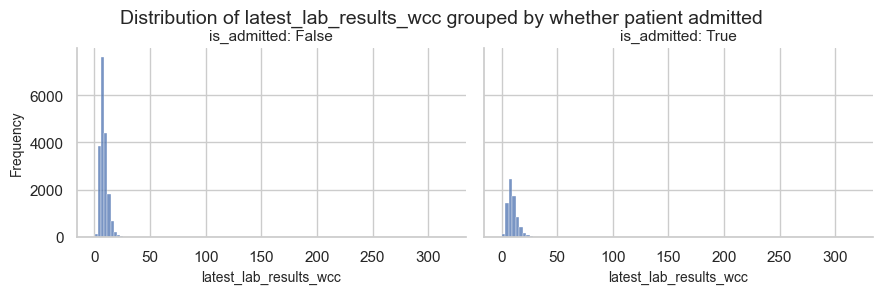

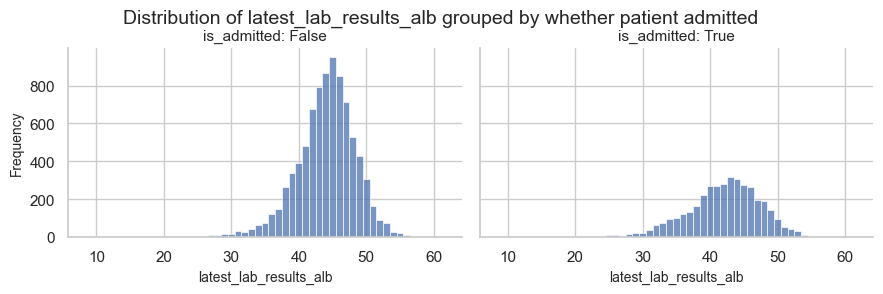

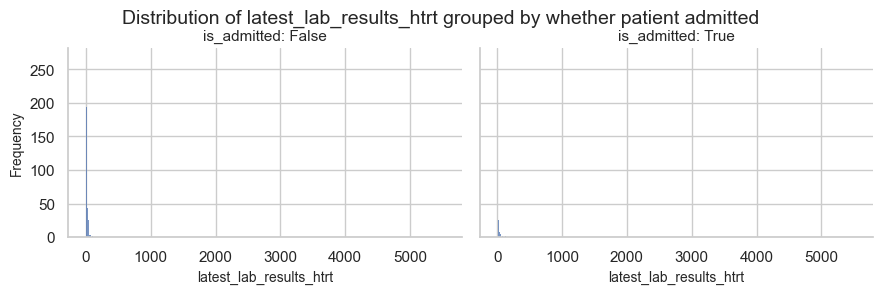

In [67]:
for col_name in [item for item in dict_cols['lab orders and results'] if str(item).startswith('latest') ]:
    plot_data_distributions(ed_visits, col_name, 'is_admitted', 'whether patient admitted', plot_type='hist')

### Consults variables

The `has_consultation` variable records whether a referral request was made to another service or specialty up to the point of the snapshot. The sequence of referrals up to that point is recorded in `consultation_sequence` and the final sequence, at the end of the ED visit in `final_sequence`. `specialty` records the specialty that the patient was admitted under, if admitted. 

The first plot shows that the number of admitted patients with consult requests at the time of the snapshots is about the same as those without. The group without consult requests will have their later in the visit, after the snapshot was recorded.

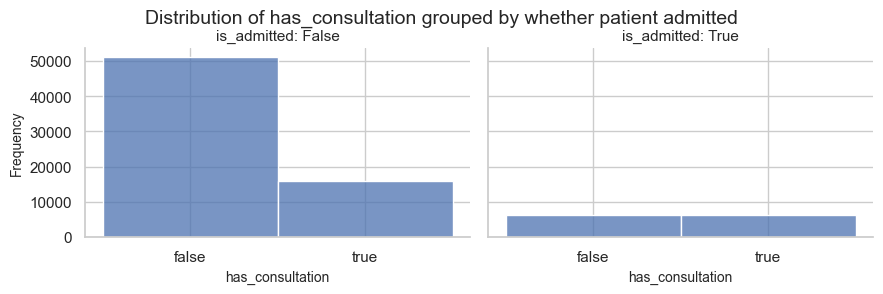

In [68]:
plot_data_distributions(ed_visits, 'has_consultation', 'is_admitted', 'whether patient admitted', plot_type='hist')

A very small number of non-admitted patients have a specialty of admission recorded. These are most likely patients referred from ED to SDEC, which we don't include in the admitted patients.

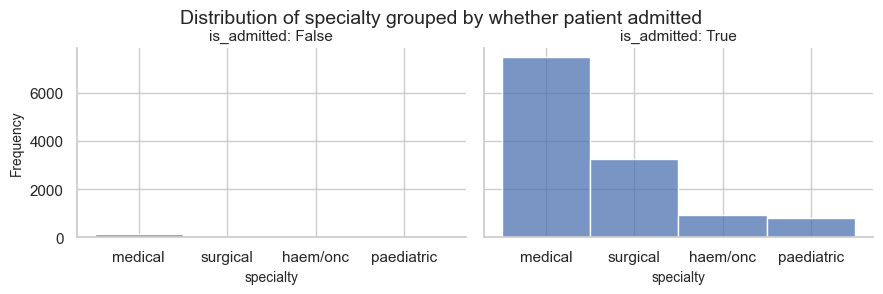

In [69]:
plot_data_distributions(ed_visits, 'specialty', 'is_admitted', 'whether patient admitted', plot_type='hist')

## Explore inpatient arrivals dataset

The inpatient_arrivals dataset records all of the arrival dates and and times of patients who were later admitted to a ward. Other information is also recorded, such as sex and child status, as will as specialty of admission. This dataset will be used to predict the number of patients yet-to-arrive at the time of prediction. 

In [70]:
inpatient_arrivals.head()

,training_validation_test,arrival_datetime,sex,specialty,is_child,is_admitted
0,train,2031-04-24 19:21:00+00:00,M,haem/onc,false,True
1,train,2031-04-25 12:42:00+00:00,F,medical,false,True
2,train,2031-03-20 19:54:00+00:00,F,haem/onc,false,True
3,train,2031-03-04 22:03:00+00:00,F,haem/onc,false,True
4,train,2031-03-01 11:10:44+00:00,M,surgical,false,True


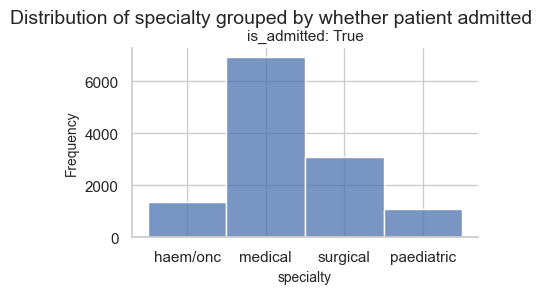

In [71]:
# temporarily add is_admitted column to arrivals dataset, to be able to use the plot_data_distributions function
inpatient_arrivals['is_admitted'] = True
plot_data_distributions(inpatient_arrivals, 'specialty', 'is_admitted', 'whether patient admitted', plot_type='hist')

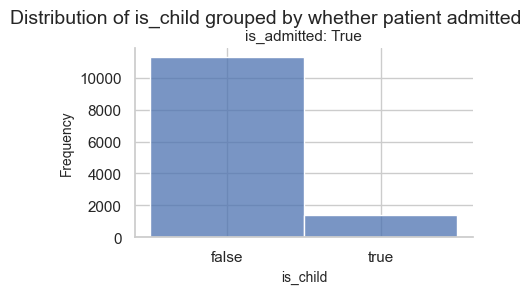

In [72]:
plot_data_distributions(inpatient_arrivals, 'is_child', 'is_admitted', 'whether patient admitted', plot_type='hist')

## Summary

This notebook has shown how to load files that have been provided, and shows some plots of the variables included. This is an illustrative dataset, showing the type of variables that were used for the analysis at UCLH. Other sites will have different data. 